In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from scipy.integrate import odeint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import json
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)
print("Setting default device to: ", device)
from PINN import CausalTrainingGradientBalancingODePINN, OdePINN, MLP_UModel, ThetaModel, MosquitoPINN
from PINNModels import MLP, LambdaLayer, ConstantVariable, LearnableVariable

Setting default device to:  cuda
Setting default device to:  cuda
Setting default device to:  cuda


# Simulation Setup

In [2]:
def get_params_culex(T=10,):
    alpha = 38
    params = {
        "gamma_Aem": 1.143,
        "gamma_Ab": 0.885,
        "gamma_Ao": 2.0,
        "f_E": np.maximum(0, 0.16 * (np.exp(0.105 * (T-10)) - np.exp(0.105*(alpha-10) - (alpha-T)/(5.007)))),
        "f_P": np.maximum(0, 0.021 * (np.exp(0.162 * (T-10)) - np.exp(0.162*(alpha-10) - (alpha-T)/5.007))),
        "f_Ag": np.maximum(0, (T-9.8)/64.4),
        "mu_E": 0,
        "mu_L": 0.0304,
        "mu_P": 0.0146,
        "mu_em": 0.1,
        "mu_r": 0.08,
        "mu_A": 1/43,
        "kappa_L": 8e8,
        "kappa_P": 1e7,
        "sigma": 0.5,
        "beta_1": 141,
        "beta_2": 80,
    }
    params['m_A'] = np.maximum(-0.005941 + 0.002965 * T, params['mu_A'])
    params["f_L"] = params['f_P'] / 1.65
    params['m_E'] = params["mu_E"]
    params["m_L"] = params["mu_L"] + np.exp(-T/2)
    params["m_P"] = params["mu_P"] + np.exp(-T/2)
    return params

# Define the system of equations for numerical solution
def system(u, t, get_temperature, get_params):
    """
    inputs: a vector of  [E, L, P, Aem, Ab1, Ag1, Ao1, Ab2, Ag2, Ao2]
                          0  1  2  3    4    5    6    7    8    9
    """
    E, L, P, Aem, Ab1, Ag1, Ao1, Ab2, Ag2, Ao2 = u
    # get_temperature, get_params = args

    T = get_temperature(t)
    params = get_params(T)

    rescale_params = {'E': 1, 'L': 1, 'P': 1, 'Aem': 1, 'Ab1': 1, 'Ag1': 1, 'Ao1': 1, 'Ab2': 1, 'Ag2': 1, 'Ao2': 1}

    dE_dt = 1 / rescale_params['E'] * params['gamma_Ao'] * (params['beta_1'] * rescale_params['Ao1'] * Ao1 + params['beta_2'] * rescale_params['Ao2'] * Ao2) - (params['mu_E'] + params['f_E']) * E
    dL_dt = 1 / rescale_params['L'] * rescale_params['E'] * params['f_E'] * E - (params['m_L'] * (1 + L * rescale_params['L'] / params['kappa_L']) + params['f_L']) * L
    dP_dt = 1 / rescale_params['P'] * rescale_params['L'] * params['f_L'] * L - (params['m_P'] + params['f_P']) * P
    dAem_dt = 1 / rescale_params['Aem'] * params['f_P'] * rescale_params['P'] * P * params['sigma'] * np.exp(- params['mu_em'] * (1 + P * rescale_params['P'] / params['kappa_P'])) - (params['m_A'] + params['gamma_Aem']) * Aem
    dAb1_dt = 1 / rescale_params['Ab1'] * rescale_params['Aem'] * params['gamma_Aem'] * Aem - (params['m_A'] + params['mu_r'] + params['gamma_Ab']) * Ab1
    dAg1_dt = 1 / rescale_params['Ag1'] * rescale_params['Ab1'] * params['gamma_Ab'] * Ab1 - (params['m_A'] + params['f_Ag']) * Ag1
    dAo1_dt = 1 / rescale_params['Ao1'] * rescale_params['Ag1'] * params['f_Ag'] * Ag1 - (params['m_A'] + params['mu_r'] + params['gamma_Ao']) * Ao1
    dAb2_dt = 1 / rescale_params['Ab2'] * params['gamma_Ao'] * (rescale_params['Ao1'] * Ao1 + rescale_params['Ao2'] * Ao2) - (params['m_A'] + params['mu_r'] + params['gamma_Ab']) * Ab2
    dAg2_dt = 1 / rescale_params['Ag2'] * rescale_params['Ab2'] * params['gamma_Ab'] * Ab2 - (params['m_A'] + params['f_Ag']) * Ag2
    dAo2_dt = 1 / rescale_params['Ao2'] * rescale_params['Ag2'] * params['f_Ag'] * Ag2 - (params['m_A'] + params['mu_r'] + params['gamma_Ao']) * Ao2

    return [dE_dt, dL_dt, dP_dt, dAem_dt, dAb1_dt, dAg1_dt, dAo1_dt, dAb2_dt, dAg2_dt, dAo2_dt]


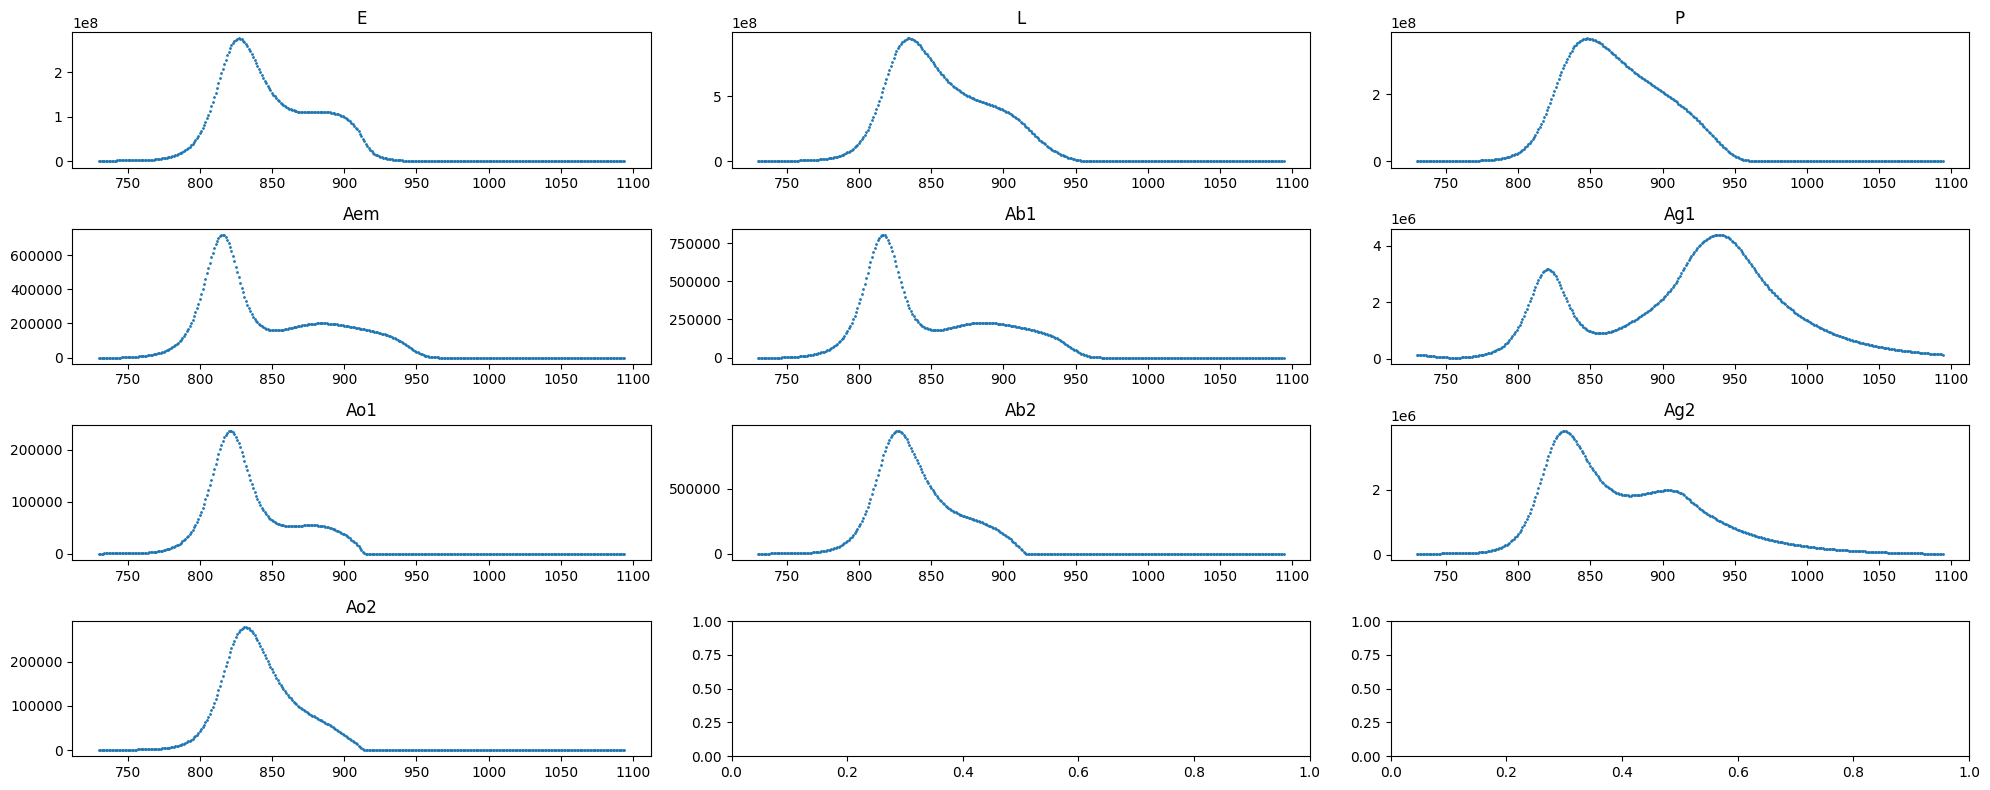

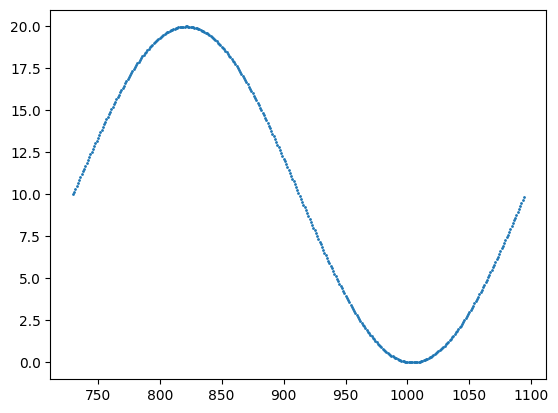

In [3]:
# Time range for the solution

def get_temperature(t):
    return 10 * np.sin(2 * np.pi / 365 * t) + 10
t_range = np.linspace(0, 365*3, 365*3*1000+1)

simulate_results = odeint(func=system, y0=np.ones((10,)) * 300, t=t_range, args=(get_temperature, get_params_culex,))


idx = np.isin(t_range, np.arange(365*2, 365*3))
t_data = torch.tensor(t_range[idx],).view(-1, 1)
u_data = torch.tensor(simulate_results[idx] )
a_data = get_temperature(t_data.detach().cpu().numpy())
a_data = torch.tensor(a_data)
params_data = get_params_culex(get_temperature(t_data.cpu().numpy()))
# for key in params_data:
#     params_data[key] = torch.tensor(params_data[key] * np.ones((t_data.shape[0], 1)))
# assert t_data.shape[0] == np.arange(365*2, 365*3).shape[0]

# Create subplots for each index from 0 to 9
fig, axs = plt.subplots(4, 3, figsize=(20, 8)) # Adjusting the size for better visualization

mosquito_stages = ["E", "L", "P", "Aem", "Ab1", "Ag1", "Ao1", "Ab2", "Ag2", "Ao2"]
for index in range(10):
    ax = axs[index//3, index%3]  # Adjusting the indexing for the new layout
    # ax.plot(t_range[idx[0]:idx[-1]], simulate_results[:, index][idx[0]:idx[-1]], ) 
    ax.scatter(t_data.detach().cpu().numpy(), u_data[:, index].detach().cpu().numpy(), s=1)
    ax.set_title(mosquito_stages[index])

plt.tight_layout()
plt.show()

plt.figure()
# plot scatter a_data
plt.scatter(t_data.detach().cpu().numpy(), a_data.detach().cpu().numpy(), s=1)

In [4]:
def plot_u_pred(mosquito_pinn, t_data, u_data, data_plot):
    if type(mosquito_pinn) == tuple:
        t_torch = mosquito_pinn[0]
        u_pred = mosquito_pinn[1]
    else:
        t_torch = torch.tensor(t_data).view(-1, 1)
        u_pred = mosquito_pinn.predict_u(t_torch)

    t_torch = t_torch.cpu().detach().numpy()
    u_pred = u_pred.cpu().detach().numpy()

    t_true = t_data.cpu().detach().numpy()
    u_true = u_data.cpu().detach().numpy()

    fig, axs = plt.subplots(4, 3, figsize=(20, 8)) # Adjusting the size for better visualization
    mosquito_stages = ["E", "L", "P", "Aem", "Ab1", "Ag1", "Ao1", "Ab2", "Ag2", "Ao2"]


    for index in range(10):
        ax = axs[index//3, index%3]  # Adjusting the indexing for the new layout
        ax.plot(t_true, u_true[:, index], c=u'#1f77b4', label=f"u_true", linewidth=3)
        ax.scatter(data_plot[0], data_plot[1][:, index], c=u'#1f77b4', label=f"u_data", s=50)
        ax.plot(t_torch, u_pred[:, index], "--", c=u'#ff7f0e', label=f"u_pred", linewidth=3)
        ax.xlim = (t_torch[0], t_torch[-1])

    for index in range(10):
        ax = axs[index//3, index%3]  # Adjusting the indexing for the new layout
        ax.legend()
        ax.set_title(mosquito_stages[index])
    plt.tight_layout()
    plt.show()

def plot_theta_pred(mosquito_pinn, t_data, params_data):
    t_torch = torch.tensor(t_data)
    params_pred = mosquito_pinn.predict_theta(t_torch)

    t_torch = t_torch.cpu().detach().numpy()
    for key in params_pred.keys():
        params_pred[key] = params_pred[key].cpu().detach().numpy()

    fig, axs = plt.subplots(4, 5, figsize=(20, 10)) # Adjusting the size for better visualization
    for index, key in enumerate(params_pred.keys()):
        ax = axs[index//5, index%5]  # Adjusting the indexing for the new layout
        ax.set_title(key)
        if type(mosquito_pinn.theta_model.theta_model[key]) in [LearnableVariable,]:
            ax.bar(["true", "pred"], [params_data[key], params_pred[key][0,0]], color=[u'#1f77b4', u'#ff7f0e'])
        else:
            ax.plot(t_torch, params_data[key] * np.ones_like(t_torch), color=u'#1f77b4')
            if type(mosquito_pinn.theta_model.theta_model[key]) not in [ConstantVariable,]:
                ax.plot(t_torch, params_pred[key], "--", color=u'#ff7f0e')
            
        if type(mosquito_pinn.theta_model.theta_model[key]) not in [ConstantVariable,]:
            rmse = np.sqrt(np.mean((params_data[key] - params_pred[key])**2))
            mdape = np.median(np.abs(params_data[key] - params_pred[key]) / (np.abs(params_data[key]) + 1e-5))
            print(f"{key}: MdAPE {mdape*100:.4f}, RMSE {rmse:.6f}")

    total_rmse = np.sqrt(np.mean([(params_data[key] - params_pred[key])**2 for key in params_pred.keys() 
                                if type(mosquito_pinn.theta_model.theta_model[key]) not in [ConstantVariable,]]))    
    print(f"Total RMSE: {total_rmse:.6f}")
    plt.tight_layout()
    plt.show()


# PINN 1: original PINN framework

In [5]:
global_T_domain = [t_data.min().item(), t_data.max().item()]
global_T_domain

[730.0, 1094.0]

In [6]:
# n_subdomains = 12
# subdomain_size = (global_T_domain[1] - global_T_domain[0]) / n_subdomains
# overlap_size = 0.1 * subdomain_size # pad both sides
# t_init = t_data[:1]
# u_init = u_data[:1]
# for i in range(n_subdomains):
#     T_training_subdomain = [global_T_domain[0] + i * subdomain_size - overlap_size, global_T_domain[0] + (i+1) * subdomain_size + overlap_size]
#     T_training_subdomain[0] = max(T_training_subdomain[0], global_T_domain[0])
#     T_training_subdomain[1] = min(T_training_subdomain[1], global_T_domain[1])
#     T_prediction_subdomain = [global_T_domain[0] + i * subdomain_size, global_T_domain[0] + (i+1) * subdomain_size]
#     T_prediction_subdomain[0] = max(T_prediction_subdomain[0], global_T_domain[0])
#     T_prediction_subdomain[1] = min(T_prediction_subdomain[1], global_T_domain[1])

#     t_data_subdomain = t_data[((t_data >= T_training_subdomain[0]) & (t_data <= T_training_subdomain[1])).reshape(-1)]
#     u_data_subdomain = u_data[((t_data >= T_training_subdomain[0]) & (t_data <= T_training_subdomain[1])).reshape(-1)]
#     U_subdomain = [u_data_subdomain.min(axis=0).values, u_data_subdomain.max(axis=0).values]
#     U_subdomain_mean = (U_subdomain[0] + U_subdomain[1]) / 2
#     U_subdomain[0] = torch.minimum(U_subdomain_mean - 1.0, U_subdomain[0])
#     U_subdomain[1] = torch.maximum(U_subdomain_mean + 1.0, U_subdomain[1])
    
#     checkpoint_dir = "checkpoints/PINN_Mosquito_forward_Subdomain_{}".format(i)

#     if checkpoint_dir is not None:
#         if not os.path.exists(checkpoint_dir):
#             os.makedirs(checkpoint_dir)
#         final_checkpoint = os.path.join(checkpoint_dir, 'model_final.pt')

#     mosquito_pinn = MosquitoPINN(T_domain=T_training_subdomain,
#                                 U_domain=U_subdomain,
#                                 u_data=(t_init, u_init),
#                                 lambda_alpha=0.9, 
#                                 lambda_update=100, 
#                                 n_gradual_steps=100000, 
#                                 n_warmup_steps=10000, 
#                                 checkpoint_dir=checkpoint_dir)

#     if os.path.exists(final_checkpoint):
#         mosquito_pinn.load_model(final_checkpoint)
#     else:
        
#         logs = mosquito_pinn.train(n_steps=300000, 
#                                    n_epoches_per_evaluation=100,
#                                    n_patience=100,)
        
#     t_init = torch.linspace(T_prediction_subdomain[1], T_training_subdomain[1], 100).view(-1, 1)
#     u_init = mosquito_pinn.predict_u(t_init).detach()

### Plotting

In [17]:
list_t_pred = []
list_u_pred = []

n_subdomains = 12
subdomain_size = (global_T_domain[1] - global_T_domain[0]) / n_subdomains
overlap_size = 0.1 * subdomain_size # pad both sides
t_init = t_data[:1]
u_init = u_data[:1]
for i in range(n_subdomains):
    T_training_subdomain = [global_T_domain[0] + i * subdomain_size - overlap_size, global_T_domain[0] + (i+1) * subdomain_size + overlap_size]
    T_training_subdomain[0] = max(T_training_subdomain[0], global_T_domain[0])
    T_training_subdomain[1] = min(T_training_subdomain[1], global_T_domain[1])
    T_prediction_subdomain = [global_T_domain[0] + i * subdomain_size, global_T_domain[0] + (i+1) * subdomain_size]
    T_prediction_subdomain[0] = max(T_prediction_subdomain[0], global_T_domain[0])
    T_prediction_subdomain[1] = min(T_prediction_subdomain[1], global_T_domain[1])

    t_data_subdomain = t_data[((t_data >= T_training_subdomain[0]) & (t_data <= T_training_subdomain[1])).reshape(-1)]
    u_data_subdomain = u_data[((t_data >= T_training_subdomain[0]) & (t_data <= T_training_subdomain[1])).reshape(-1)]
    U_subdomain = [u_data_subdomain.min(axis=0).values, u_data_subdomain.max(axis=0).values]
    U_subdomain_mean = (U_subdomain[0] + U_subdomain[1]) / 2
    U_subdomain[0] = torch.minimum(U_subdomain_mean - 1.0, U_subdomain[0])
    U_subdomain[1] = torch.maximum(U_subdomain_mean + 1.0, U_subdomain[1])
    
    checkpoint_dir = "checkpoints/PINN_Mosquito_forward_Subdomain_{}".format(i)

    if checkpoint_dir is not None:
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        final_checkpoint = os.path.join(checkpoint_dir, 'model_final.pt')

    mosquito_pinn = MosquitoPINN(T_domain=T_training_subdomain,
                                U_domain=U_subdomain,
                                u_data=(t_init, u_init),
                                lambda_alpha=0.9, 
                                lambda_update=100, 
                                n_gradual_steps=100000, 
                                n_warmup_steps=10000, 
                                checkpoint_dir=checkpoint_dir)

    if os.path.exists(final_checkpoint):
        print("Loading model from: ", final_checkpoint)
        mosquito_pinn.load_model(final_checkpoint)
    else:
        continue
        logs = mosquito_pinn.train(n_steps=300000, 
                                   n_epoches_per_evaluation=100,
                                   n_patience=100,)


    t_pred = t_data[((t_data >= T_prediction_subdomain[0]) & (t_data < T_prediction_subdomain[1])).reshape(-1)]
    if i == n_subdomains - 1:
        t_pred = t_data[((t_data >= T_prediction_subdomain[0]) & (t_data <= T_prediction_subdomain[1])).reshape(-1)]
    u_pred = mosquito_pinn.predict_u(t_pred).detach()

    list_t_pred.append(t_pred)
    list_u_pred.append(u_pred)

t_pred = torch.cat(list_t_pred, dim=0)
u_pred = torch.cat(list_u_pred, dim=0)

Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_0/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_1/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_2/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_3/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_4/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_5/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_6/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_7/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_8/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_9/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_10/model_final.pt
Loading model from:  checkpoints/PINN_Mosquito_forward_Subdomain_11/model_final.pt


(6.914271110571065, 275424355.7560074)

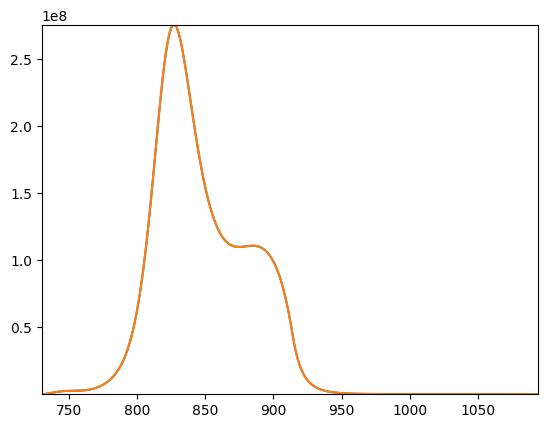

In [18]:
plt.plot(t_pred.detach().cpu().numpy(), u_pred[:,0].detach().cpu().numpy())
plt.plot(t_data.detach().cpu().numpy(), u_data[:,0].detach().cpu().numpy())
plt.xlim([t_pred.min().item(), t_pred.max().item()])
plt.ylim(u_pred[:,0].min().item(), u_pred[:,0].max().item())

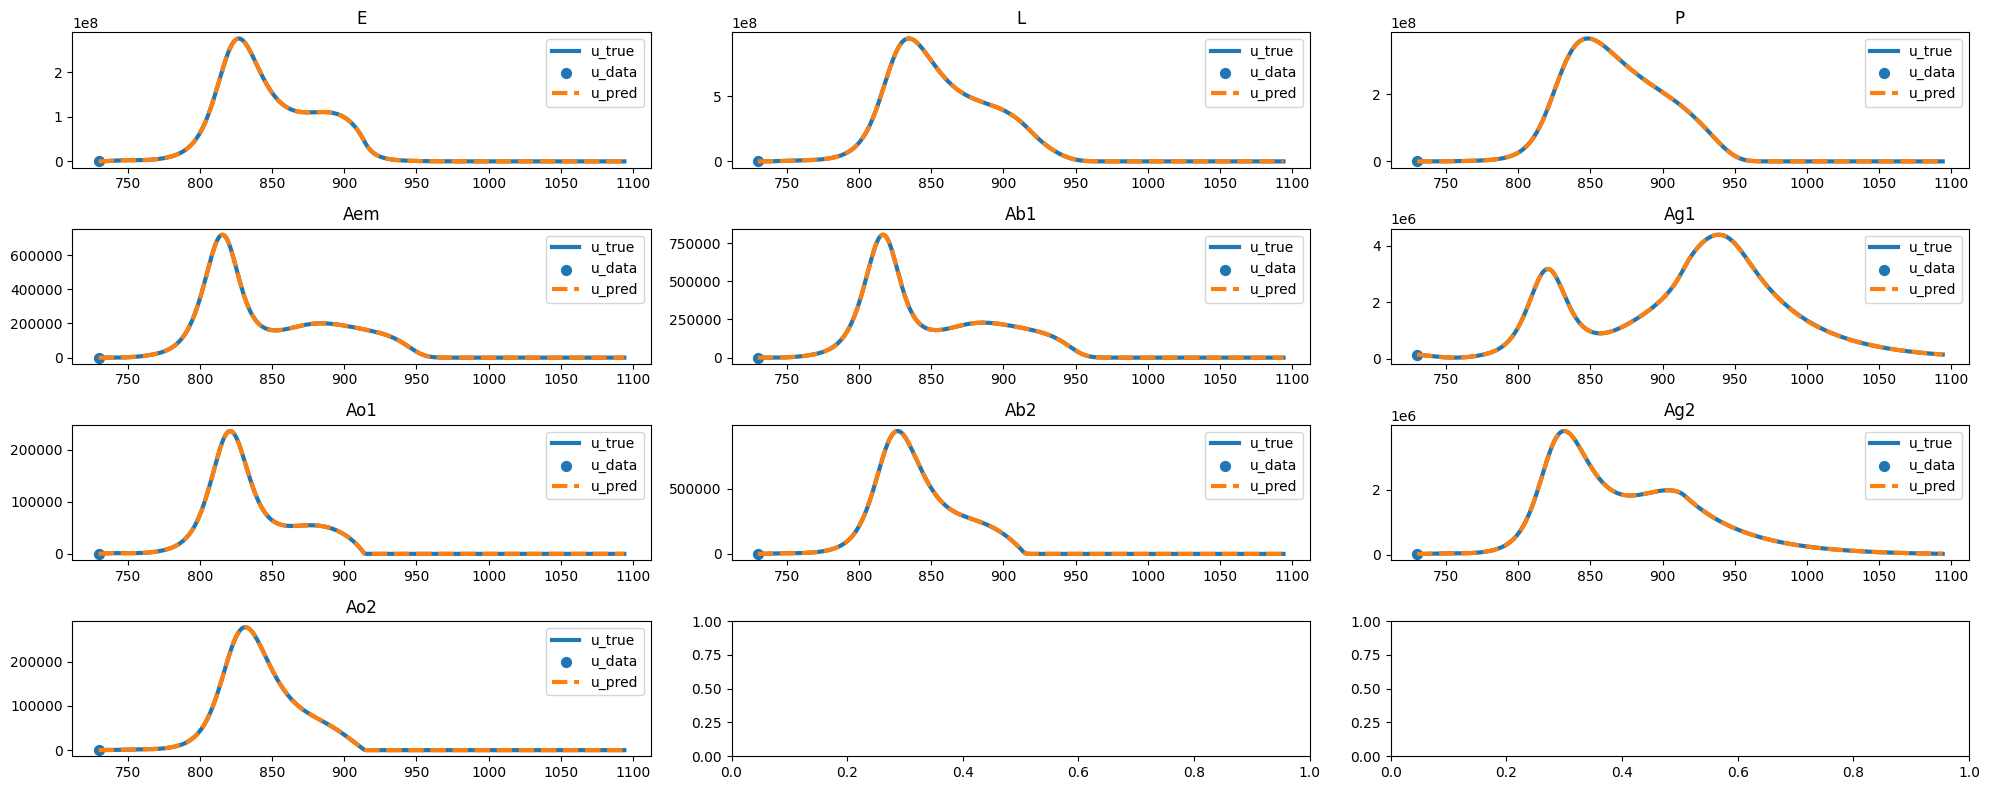

In [19]:
plot_u_pred((t_pred, u_pred), t_data, u_data, [t_init.detach().cpu().numpy(), u_init.detach().cpu().numpy()])

In [21]:


mosquito_stages = ["E", "L", "P", "Aem", "Ab1", "Ag1", "Ao1", "Ab2", "Ag2", "Ao2"]
df_metrics = []
for index, stage in enumerate(mosquito_stages):
    rmse = torch.sqrt(torch.mean((u_pred[:, index] - u_data[:, index]).pow(2))).item()
    mae = torch.mean(torch.abs(u_pred[:, index] - u_data[:, index])).item()
    mdape = torch.median(torch.abs(u_pred[:, index] - u_data[:, index]) / (torch.abs(u_data[:, index]) + 1e-5)).item()
    df_metrics.append({"stage": stage, "rmse": rmse, "mae": mae, "mdape": mdape})

#general error
rmse = torch.sqrt(torch.mean((u_pred - u_data).pow(2))).item()
mae = torch.mean(torch.abs(u_pred - u_data)).item()
mdape = torch.median(torch.abs(u_pred - u_data) / (torch.abs(u_data) + 1e-5)).item()
df_metrics.append({"stage": "Overall", "rmse": rmse, "mae": mae, "mdape": mdape})
df_metrics = pd.DataFrame(df_metrics)
df_metrics

,stage,rmse,mae,mdape
0,E,7323.481235,4896.747984,0.000524
1,L,52702.447572,23869.456426,0.000546
2,P,75105.773400,23118.919141,0.000613
3,Aem,126.065089,47.008593,0.000625
4,Ab1,175.947111,62.768273,0.000671
5,Ag1,5398.096949,2688.997498,0.000376
6,Ao1,7.863538,3.730878,0.004027
7,Ab2,21.374103,11.561542,0.001695
8,Ag2,1130.936616,417.980948,0.000216
9,Ao2,6.557427,3.431917,0.010780


# END